In [1]:
import os
import tarfile
import random
import gc
import warnings
import itertools

import numpy as np
import pandas as pd

import cv2
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.data import Dataset
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D, LeakyReLU, ReLU
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import Callback,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.utils import plot_model


from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_auc_score, average_precision_score

warnings.filterwarnings('ignore')

In [2]:
df_train = pd.read_csv('../input/140k-real-and-fake-faces/train.csv',index_col=0)
df_val = pd.read_csv('../input/140k-real-and-fake-faces/valid.csv',index_col=0)
df_test = pd.read_csv('../input/140k-real-and-fake-faces/test.csv',index_col=0)

In [3]:
df_train.head()

,original_path,id,label,label_str,path
0,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,31355,1,real,train/real/31355.jpg
1,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,02884,1,real,train/real/02884.jpg
2,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,33988,1,real,train/real/33988.jpg
3,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,53875,1,real,train/real/53875.jpg
4,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,24149,1,real,train/real/24149.jpg


In [4]:
df_val.head()

,original_path,id,label,label_str,path
0,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,20001,1,real,valid/real/20001.jpg
1,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,11264,1,real,valid/real/11264.jpg
2,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,19817,1,real,valid/real/19817.jpg
3,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,46851,1,real,valid/real/46851.jpg
4,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,10411,1,real,valid/real/10411.jpg


In [5]:
df_test.head()

,original_path,id,label,label_str,path
0,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,18233,1,real,test/real/18233.jpg
1,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,54317,1,real,test/real/54317.jpg
2,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,40155,1,real,test/real/40155.jpg
3,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,12875,1,real,test/real/12875.jpg
4,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,52543,1,real,test/real/52543.jpg


In [3]:
df_train = df_train.drop(columns=['original_path','id','label_str']).sample(frac=1)
df_val = df_val.drop(columns=['original_path','id','label_str']).sample(frac=1)
df_test = df_test.drop(columns=['original_path','id','label_str']).sample(frac=1)

df_train['label'] = 1 - df_train['label']
df_val['label'] = 1 - df_val['label']
df_test['label'] = 1 - df_test['label']

In [4]:
y_train = df_train['label']
X_train = df_train['path']

y_val = df_val['label']
X_val = df_val['path']

y_test = df_test['label']
X_test = df_test['path']

<BarContainer object of 2 artists>

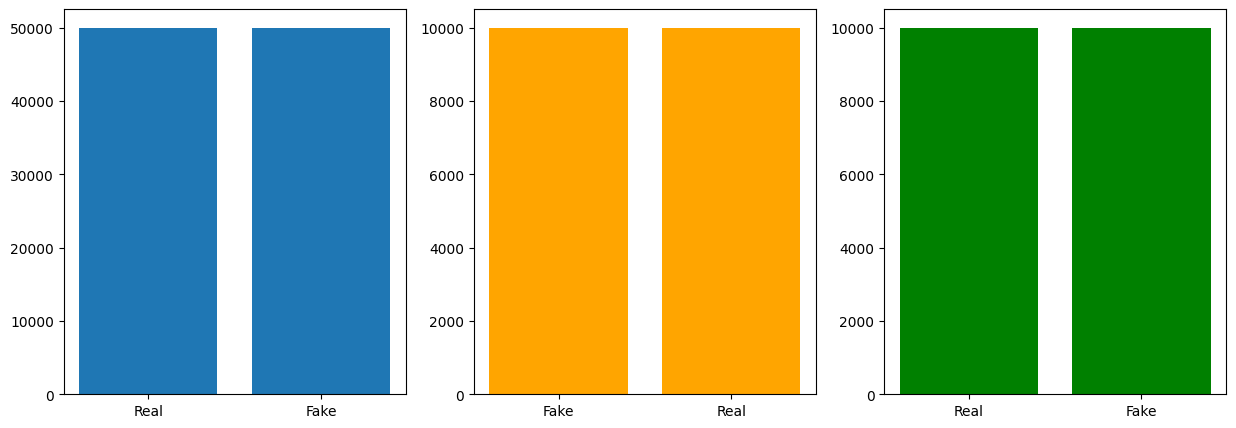

In [5]:
fig, axs = plt.subplots(1,3,figsize=(15,5))
axs[0].bar(y_train.value_counts().index, y_train.value_counts(), tick_label=['Real','Fake'])
axs[1].bar(y_val.value_counts().index, y_val.value_counts(), tick_label=['Real','Fake'], color='orange')
axs[2].bar(y_test.value_counts().index, y_test.value_counts(), tick_label=['Real','Fake'], color='green')

<BarContainer object of 2 artists>

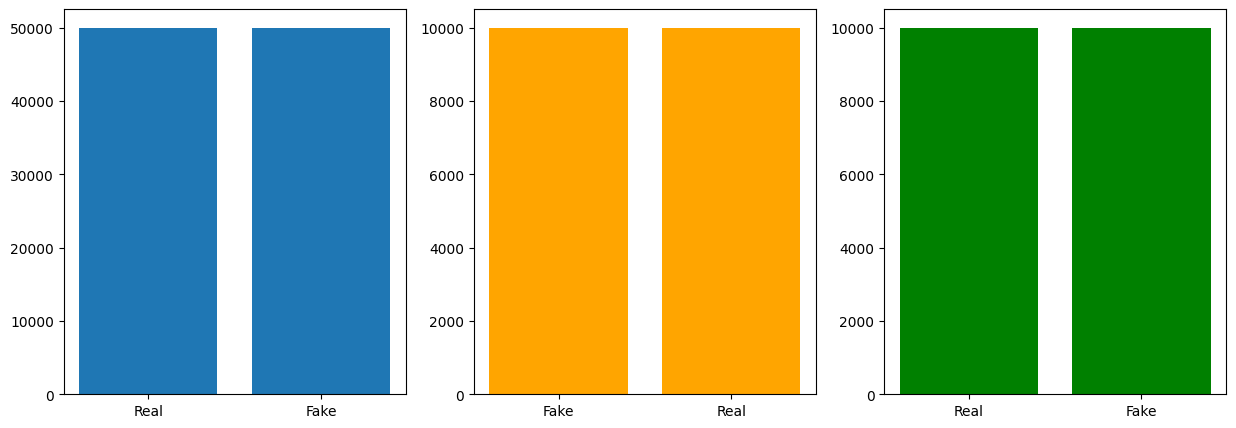

In [6]:
fig, axs = plt.subplots(1,3,figsize=(15,5))
axs[0].bar(y_train.value_counts().index, y_train.value_counts(), tick_label=['Real','Fake'])
axs[1].bar(y_val.value_counts().index, y_val.value_counts(), tick_label=['Real','Fake'], color='orange')
axs[2].bar(y_test.value_counts().index, y_test.value_counts(), tick_label=['Real','Fake'], color='green')

In [7]:
X_train = X_train.map(lambda x: '../input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/' + x)
X_val = X_val.map(lambda x: '../input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/' + x)
X_test = X_test.map(lambda x: '../input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/' + x)

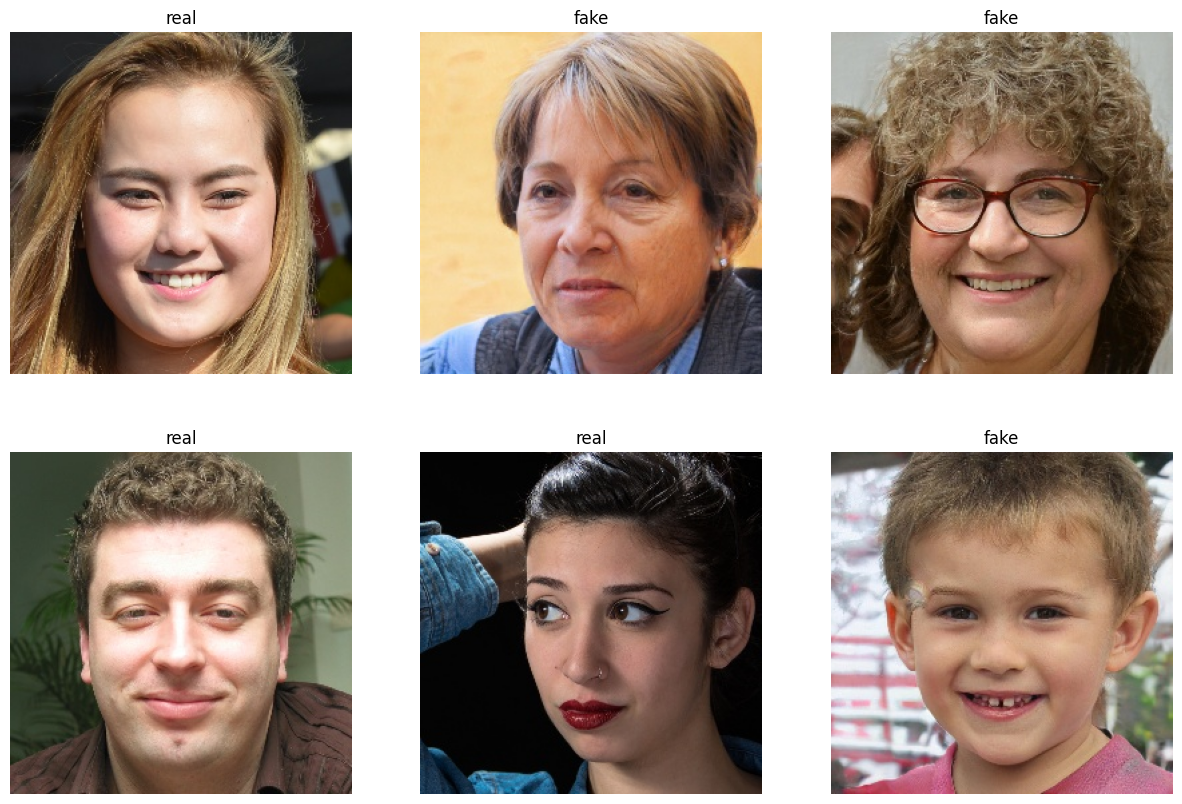

In [9]:
base_path = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake'
X_train_cleaned = X_train.apply(lambda x: x[x.find('train/'):])
label_arg = {0: 'real', 1: 'fake'}
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
for i in range(2):
    for j in range(3):
        idx = np.random.randint(0, X_train_cleaned.shape[0])
        img_path = os.path.join(base_path, X_train_cleaned.iloc[idx])
        img = Image.open(img_path)
        label = y_train.iloc[idx]
        axs[i, j].imshow(img)
        axs[i, j].set_title(label_arg[label])
        axs[i, j].axis('off')


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
ig = ImageDataGenerator(rescale=1./255.)
base_path = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/'
train_flow = ig.flow_from_directory(
    base_path + 'train/',
    target_size=(128, 128),
    batch_size=64,
    class_mode='categorical'
)

ig1 = ImageDataGenerator(rescale=1./255.)

valid_flow = ig1.flow_from_directory(
    base_path + 'valid/',
    target_size=(128, 128),
    batch_size=64,
    class_mode='categorical'
)

test_flow = ig.flow_from_directory(
    base_path + 'test/',
    target_size=(128, 128),
    batch_size=1,
    shuffle = False,
    class_mode='categorical'
)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [15]:
from functools import partial
from tensorflow.keras.layers import Dropout, BatchNormalization, GlobalAveragePooling2D

tf.random.set_seed(42)

DefaultConv2D = partial(
    tf.keras.layers.Conv2D, kernel_size=3, padding="same",
    activation="relu", kernel_initializer="he_normal"
)

model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[128, 128, 3]),
    BatchNormalization(),
    tf.keras.layers.MaxPool2D(),
    Dropout(0.25),

    DefaultConv2D(filters=128),
    BatchNormalization(),
    tf.keras.layers.MaxPool2D(),
    Dropout(0.25),

    DefaultConv2D(filters=256),
    BatchNormalization(),
    tf.keras.layers.MaxPool2D(),
    Dropout(0.25),

    GlobalAveragePooling2D(),
    tf.keras.layers.Dense(units=64, activation="relu"),
    Dropout(0.5),
    tf.keras.layers.Dense(units=2, activation="softmax")
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 128, 128, 64)        │           9,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 396,866 (1.51 MB)

 Trainable params: 395,970 (1.51 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)

history = model.fit(
    train_flow,
    epochs=20,
    validation_data=valid_flow,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 842s 537ms/step - accuracy: 0.6560 - loss: 0.6181 - val_accuracy: 0.5580 - val_loss: 0.8578 - learning_rate: 0.0010
Epoch 2/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 287s 183ms/step - accuracy: 0.7801 - loss: 0.4685 - val_accuracy: 0.8268 - val_loss: 0.3858 - learning_rate: 0.0010
Epoch 3/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 244s 155ms/step - accuracy: 0.8295 - loss: 0.3866 - val_accuracy: 0.7368 - val_loss: 0.5379 - learning_rate: 0.0010
Epoch 4/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 229s 146ms/step - accuracy: 0.8588 - loss: 0.3322 - val_accuracy: 0.8741 - val_loss: 0.2983 - learning_rate: 0.0010
Epoch 5/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 234s 149ms/step - accuracy: 0.8772 - loss: 0.2958 - val_accuracy: 0.8725 - val_loss: 0.3055 - learning_rate: 0.0010
Epoch 6/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 239s 152ms/step - accuracy: 0.8927 - loss: 0.2634 - val_accuracy: 0.8704 - val_loss: 0.3187 - learning_rate: 0.0010
Epoch 7/30
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/s

In [11]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

pretrained = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
pretrained.trainable = False  

model = Sequential([
    pretrained,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(512, activation="relu"),
    Dropout(0.5),
    Dense(2, activation="softmax") 
])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)

model.compile(
    loss="categorical_crossentropy", 
    optimizer="nadam",
    metrics=["accuracy"]
)

model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 4, 4, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,646,018 (94.02 MB)

 Trainable params: 1,054,210 (4.02 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

In [ ]:
history = model.fit(
    train_flow,
    epochs=20,
    validation_data=valid_flow,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1190s 752ms/step - accuracy: 0.6495 - loss: 0.6320 - val_accuracy: 0.6883 - val_loss: 0.5885 - learning_rate: 0.0010
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 295s 188ms/step - accuracy: 0.6850 - loss: 0.5933 - val_accuracy: 0.7052 - val_loss: 0.5738 - learning_rate: 0.0010
Epoch 3/20
 529/1563 ━━━━━━━━━━━━━━━━━━━━ 1:50 107ms/step - accuracy: 0.7027 - loss: 0.5743

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy and loss curves for both models
def plot_training(history1, label1, history2, label2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Accuracy plot
    ax1.plot(history1.history['accuracy'], label=f'{label1} - Train')
    ax1.plot(history1.history['val_accuracy'], label=f'{label1} - Val')
    ax1.plot(history2.history['accuracy'], label=f'{label2} - Train')
    ax1.plot(history2.history['val_accuracy'], label=f'{label2} - Val')
    ax1.set_title('Model Accuracy Comparison')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Loss plot
    ax2.plot(history1.history['loss'], label=f'{label1} - Train')
    ax2.plot(history1.history['val_loss'], label=f'{label1} - Val')
    ax2.plot(history2.history['loss'], label=f'{label2} - Train')
    ax2.plot(history2.history['val_loss'], label=f'{label2} - Val')
    ax2.set_title('Model Loss Comparison')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# Call the function with both histories
plot_training(history_custom, "Custom CNN", history_resnet, "ResNet50")


In [ ]:
y_pred = model.predict(test_flow)
y_pred_labels = np.argmax(y_pred, axis=1)